# Loading NYU Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
class DepthDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files=[]
        folders=os.listdir(data_dir+'/RGB')
        for folder in folders:
            subfolders=os.listdir(data_dir+'/RGB/'+folder)
            for subfolder in subfolders:
                if subfolder.startswith('.'):
                    continue
                files=os.listdir(data_dir+'/RGB/'+folder+'/'+subfolder)
                for file in files:
                    if file.endswith('.mat'):
                        self.data_files.append(folder+'/'+ subfolder+'/'+file)
            self.data_dir=data_dir
#         sort(self.data_files)      

    def __getitem__(self, index):
        name=self.data_files[index]
        img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
        depth=torch.from_numpy(h5py.File(self.data_dir+'/DEP/'+name,'r')['depthOut'].value).float()
        return img,depth

    def __len__(self):
        return len(self.data_files)

In [3]:
dataset=DepthDataset('../Data_liv')
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter((torch.randperm(self.num_samples)+self.start).long())

    def __len__(self):
        return self.num_samples

In [4]:
N=dataset.__len__()
NUM_TRAIN = int(N*0.9)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=8
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),num_workers=8)
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),num_workers=8)

NUM_TRAIN: 268 ,NUM_VAL: 30


In [5]:
# image size = [304, 228]
# depth size = [74,55]
print(len(loader_train))

34


In [6]:
#for t,(x,y) in enumerate(loader_train):
#    print(t)

In [6]:
# define network

#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # \"flatten\" the C * H * W values into a single vector per image
    

class Unflatten(nn.Module):
    def __init__(self,w,h):
        super(Unflatten,self).__init__()
        self.w=w
        self.h=h
    def forward(self, x):
        N, S = x.size() # read in N, C, H, W
        return x.view(N, self.w, self.h)  # \"flatten\" the C * H * W values into a single vector per image

class crop(nn.Module):
    def forward(self,x):
        N,C,H,W = x.size()
        return x[:,:,0:H,0:W-1].squeeze()
class printLayer(nn.Module):
    def forward(self,x):
        print('layer size:',x.size())
        #print('max element:', x.max())
        return x

In [8]:
dtype = torch.cuda.FloatTensor
#del coarse_model
prev_model=nn.Sequential(
        nn.Conv2d(3,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,80,3,stride = 2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,3,stride = 1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,100,3,stride=2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.Conv2d(100,120,3,stride=1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        #nn.ConvTranspose2d(360, 100, 3, stride = 4, padding=2,output_padding=1),
        #nn.BatchNorm2d(100),
        #nn.ReLU(),
        nn.Conv2d(120,1,1,stride=1,padding=0),
        crop()
    )
prev_model.type(dtype)

Sequential (
  (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU ()
  (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU ()
  (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU ()
  (9): Conv2d(50, 80, kernel_size=(3, 3), stride=(2, 2))
  (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU ()
  (12): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU ()
  (15): Conv2d(80, 100, kernel_size=(3, 3), stride=(2, 2))
  (16): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (17): ReLU ()
  (18): Conv2d(100, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): BatchNorm2d(120, eps=1e-05, mome

In [7]:
dtype = torch.cuda.FloatTensor
#del coarse_model
coarse_model=nn.Sequential(
        nn.Conv2d(3,50,3,stride=1, padding=1), # 304*228
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1), # 304*228
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        #nn.Conv2d(50,50,3,stride=1, padding=1), # 304*228
        #printLayer(),
        #nn.BatchNorm2d(50),
        #nn.ReLU(),
        nn.Conv2d(50,50,3,stride = 2,padding=0), # 151*113
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,80,3,stride = 2,padding=0), # 75*56
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,100,3,stride = 2,padding=1), # 38*28
        #printLayer(),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.ConvTranspose2d(100, 120, 3, stride = 2, padding=(2,1),output_padding=1), # 74*56
        #printLayer(),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        
        nn.Conv2d(120,1,1,stride=1,padding=0),
        crop()
    )
coarse_model.type(dtype)

Sequential (
  (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU ()
  (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU ()
  (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2))
  (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU ()
  (9): Conv2d(50, 80, kernel_size=(3, 3), stride=(2, 2))
  (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU ()
  (12): Conv2d(80, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU ()
  (15): ConvTranspose2d(100, 120, kernel_size=(3, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (16): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True)
  (17): ReLU ()
  (18): Conv2d(120, 1, kernel_size=(1, 1), stride=(1, 1))
  (19): crop (
  )
)

In [16]:
# if load model para:
#coarse_model = torch.load('./save_model/model_2')
# do before optimizer
del coarse_model

In [9]:


lr=5e-4
reg=1e-4
adam_optim=optim.Adam(coarse_model.parameters(),lr=lr,weight_decay=reg)

#images_var=Variable(images_pytorch.type(dtype),requires_grad=False)
#depths_var=Variable(depths_pytorch.type(dtype),requires_grad=False)

def loss_log(pred,y):
    ep = 1e-6
    N,W,H = pred.size()
    #print(pred.size())
    #print(y.size())
    pred = pred.contiguous().view(N,-1)
    y = y.view(N,-1)
    y = y+ep
    d = pred - y.log()
    d[y <= 0] = 0
    n = W*H
    loss = (d.pow(2).sum(1) / n - 0.5 / n/n * d.sum(1).pow(2)).sum()
    loss /= N
    return loss
    


In [10]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

epoch: 0 average training loss: 24.93 validation loss: 29.71
epoch: 1 average training loss: 22.38 validation loss: 26.07
epoch: 2 average training loss: 20.05 validation loss: 22.43
epoch: 3 average training loss: 18.51 validation loss: 22.78
epoch: 4 average training loss: 17.69 validation loss: 21.70


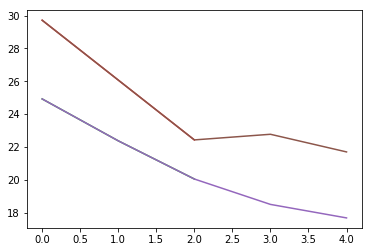

In [12]:
import pickle
print_every=200

train_losses = []
val_losses = []
def train(model, loss_fn, optimizer, num_epochs = 1, plot_every = 2):
    
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            #losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del x,y
        avg_train_loss/=num_batches
        train_losses.append(avg_train_loss)
        
        num_batches=0
        avg_val_loss=0
        for t,(x,y) in enumerate(loader_val):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss=loss_fn(pred,y_var)
            avg_val_loss+=loss.data[0]
            num_batches+=1
            del x,y
        avg_val_loss/=num_batches
        val_losses.append(avg_val_loss)
        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss,"validation loss: %.2f" %avg_val_loss)
        if(epoch % plot_every == 0):
            #with open('losses_ep'+ str(epoch)+ '.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
            #    pickle.dump([train_losses, val_losses], f)
            #torch.save(coarse_model.state_dict(), 'alldata_dict_ep'+str(epoch))
            plt.plot(train_losses)
            plt.plot(val_losses)
        
            

train(coarse_model,loss_log,adam_optim,num_epochs = 5)

epoch: 0 average training loss: 16.78 validation loss: 20.24
epoch: 1 average training loss: 16.26 validation loss: 16.95
epoch: 2 average training loss: 15.90 validation loss: 18.76
epoch: 3 average training loss: 16.31 validation loss: 19.50
epoch: 4 average training loss: 16.08 validation loss: 20.69
epoch: 5 average training loss: 15.39 validation loss: 16.84
epoch: 6 average training loss: 15.35 validation loss: 20.74
epoch: 7 average training loss: 15.79 validation loss: 17.77
epoch: 8 average training loss: 15.17 validation loss: 15.40
epoch: 9 average training loss: 15.17 validation loss: 18.84
epoch: 10 average training loss: 15.00 validation loss: 14.72
epoch: 11 average training loss: 14.65 validation loss: 18.07
epoch: 12 average training loss: 14.61 validation loss: 15.54
epoch: 13 average training loss: 14.61 validation loss: 15.08
epoch: 14 average training loss: 14.42 validation loss: 15.59


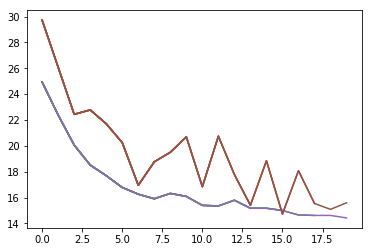

In [13]:

train(coarse_model,loss_log,adam_optim,num_epochs = 15)

epoch: 0 average training loss: 15.61 validation loss: 20.98
epoch: 1 average training loss: 15.66 validation loss: 17.70
epoch: 2 average training loss: 15.25 validation loss: 17.59
epoch: 3 average training loss: 15.35 validation loss: 17.44
epoch: 4 average training loss: 15.13 validation loss: 16.49


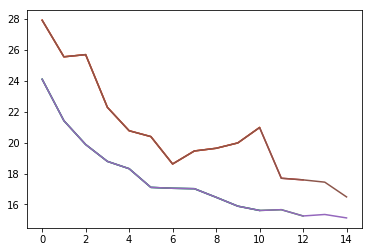

In [14]:
lr=1e-4
adam_optim=optim.Adam(prev_model.parameters(),lr=lr,weight_decay=reg)
train(prev_model,loss_log,adam_optim,num_epochs = 5)

epoch: 0 average training loss: 16.54 validation loss: 20.60
epoch: 1 average training loss: 16.82 validation loss: 19.10
epoch: 2 average training loss: 16.05 validation loss: 17.74
epoch: 3 average training loss: 15.96 validation loss: 21.04
epoch: 4 average training loss: 15.98 validation loss: 17.75


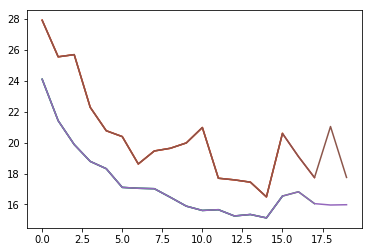

In [15]:
lr=1e-3
adam_optim=optim.Adam(prev_model.parameters(),lr=lr,weight_decay=reg)
train(prev_model,loss_log,adam_optim,num_epochs = 5)

In [19]:
lr=5e-4
adam_optim=optim.Adam(prev_model.parameters(),lr=lr,weight_decay=reg)

epoch: 0 average training loss: 12.34 validation loss: 11.69
epoch: 1 average training loss: 11.21 validation loss: 11.32
epoch: 2 average training loss: 11.16 validation loss: 11.19
epoch: 3 average training loss: 10.94 validation loss: 10.99
epoch: 4 average training loss: 10.92 validation loss: 10.78
epoch: 5 average training loss: 10.70 validation loss: 10.61
epoch: 6 average training loss: 10.37 validation loss: 10.43
epoch: 7 average training loss: 10.30 validation loss: 10.24
epoch: 8 average training loss: 10.04 validation loss: 10.06
epoch: 9 average training loss: 9.82 validation loss: 9.88


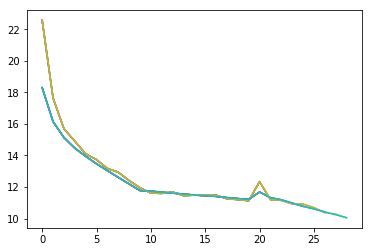

In [20]:
train(prev_model,loss_log,adam_optim,num_epochs = 10)

epoch: 0 average training loss: 5.17 validation loss: 5.34
epoch: 1 average training loss: 5.18 validation loss: 5.32
epoch: 2 average training loss: 5.12 validation loss: 5.30
epoch: 3 average training loss: 5.16 validation loss: 5.28
epoch: 4 average training loss: 5.12 validation loss: 5.25
epoch: 5 average training loss: 5.13 validation loss: 5.23
epoch: 6 average training loss: 5.13 validation loss: 5.22
epoch: 7 average training loss: 5.12 validation loss: 5.20
epoch: 8 average training loss: 5.05 validation loss: 5.18
epoch: 9 average training loss: 4.99 validation loss: 5.16


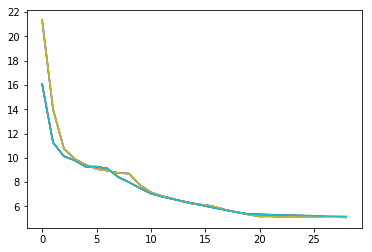

In [55]:
lr=1e-4
adam_optim=optim.Adam(coarse_model.parameters(),lr=lr,weight_decay=reg)
train(coarse_model,loss_log,adam_optim,num_epochs = 10)

In [15]:
len(train_losses)

10

In [14]:
def evaluate(loader, model):
    ep = 1e-7

    thresh_1 = 0
    thresh_2 = 0
    abs_diff = 0
    rmse = 0

    for t,(x,y) in enumerate(loader):
        x_var=Variable(x.type(dtype),requires_grad=False)
        y_var=Variable(y.type(dtype),requires_grad=False)
        model.train(False)
        pred=model(x_var)

        #print(y_var.data.cpu().numpy())
        y_var=y_var.data.cpu().numpy()
        y_var = np.exp(y_var) + ep
        pred=pred.data.cpu().numpy() + ep
        num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]

        # threshold
        thresh_mat = np.zeros_like(y_var)
        thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
        thresh_1 += np.sum(thresh_mat)
        thresh_2 += num_var
        #print('t1 = %d, t2 = %d', thresh_1, thresh_2)

        # relative absolute diffe
        abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var

        rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)
        


    abs_diff /= len(loader)
    rmse /= len(loader)

    print('percentage within threshold: ', thresh_1 / thresh_2)
    print('relative absolute diff = ', abs_diff)
    print('rmse = ', rmse)

In [17]:
evaluate(loader_val, coarse_model)

percentage within threshold:  0.923849303849
relative absolute diff =  3.83677289683
rmse =  44.211822805


In [ ]:
train(coarse_model,loss_log,adam_optim,num_epochs = 10)

In [12]:
del coarse_model

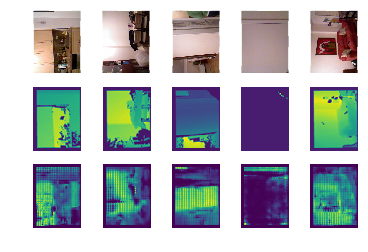

In [19]:
%matplotlib inline

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

epoch: 0 average training loss: 10.82 validation loss: 14.07
epoch: 1 average training loss: 10.83 validation loss: 14.78
epoch: 2 average training loss: 10.24 validation loss: 15.10
epoch: 3 average training loss: 11.04 validation loss: 14.46
epoch: 4 average training loss: 12.12 validation loss: 15.88
epoch: 5 average training loss: 11.55 validation loss: 14.76
epoch: 6 average training loss: 10.92 validation loss: 14.05
epoch: 7 average training loss: 10.50 validation loss: 13.78
epoch: 8 average training loss: 10.68 validation loss: 14.41
epoch: 9 average training loss: 11.07 validation loss: 14.26
epoch: 10 average training loss: 11.74 validation loss: 17.96
epoch: 11 average training loss: 13.09 validation loss: 14.92
epoch: 12 average training loss: 11.43 validation loss: 14.62
epoch: 13 average training loss: 10.22 validation loss: 13.89
epoch: 14 average training loss: 9.38 validation loss: 13.50
epoch: 15 average training loss: 8.91 validation loss: 13.87
epoch: 16 average tr

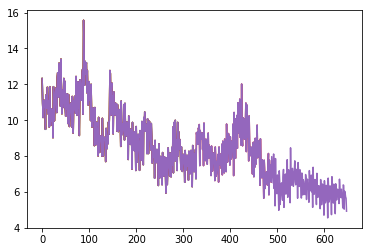

In [27]:
train(coarse_model,loss_log,adam_optim,num_epochs = 100, plot_every = 20)

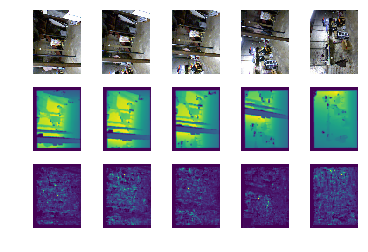

In [28]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

epoch: 0 average training loss: 1.67
epoch: 1 average training loss: 1.68
epoch: 2 average training loss: 1.82
epoch: 3 average training loss: 1.68
epoch: 4 average training loss: 1.68
epoch: 5 average training loss: 1.64
epoch: 6 average training loss: 1.70
epoch: 7 average training loss: 1.67
epoch: 8 average training loss: 1.63
epoch: 9 average training loss: 1.67
epoch: 10 average training loss: 1.57
epoch: 11 average training loss: 1.64
epoch: 12 average training loss: 1.66
epoch: 13 average training loss: 1.67
epoch: 14 average training loss: 1.65
epoch: 15 average training loss: 1.57
epoch: 16 average training loss: 1.68
epoch: 17 average training loss: 1.68
epoch: 18 average training loss: 1.67
epoch: 19 average training loss: 1.85
epoch: 20 average training loss: 1.69
epoch: 21 average training loss: 1.73
epoch: 22 average training loss: 1.65
epoch: 23 average training loss: 1.69
epoch: 24 average training loss: 1.66
epoch: 25 average training loss: 1.61
epoch: 26 average trai

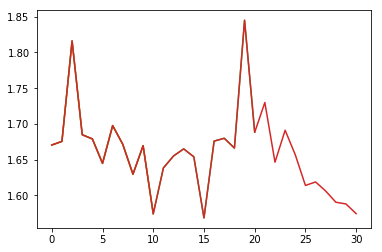

In [36]:

def train_overfit(model, loss_fn, optimizer, num_epochs = 1, plot_every = 10):
    losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        avg_train_loss/=num_batches
        num_batches=0

        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss)
        if(epoch % plot_every == 0):
            plt.plot(losses)
            

train_overfit(coarse_model,loss_log,adam_optim,40)

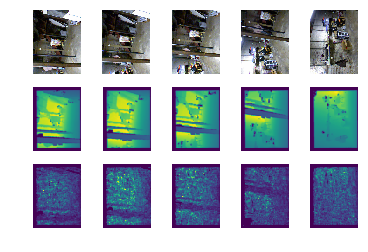

In [37]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

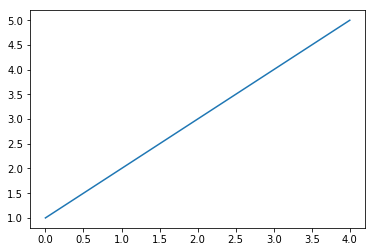

In [13]:
%matplotlib inline
a = [1,2,3,4]#np.array([1,2,3,4])
a.append(5)
plt.plot(a)

In [15]:
print(loader_train)

In [20]:
a = torch.zeros(3,3)
a[0,1] = 2
a[0,2] = 4
b = torch.sum(a,0)

print(a)
print(b)


 0  2  4
 0  0  0
 0  0  0
[torch.FloatTensor of size 3x3]


 0  2  4
[torch.FloatTensor of size 1x3]




 0  2  4
 0  0  0
 0  0  0
[torch.FloatTensor of size 3x3]


 6
 0
 0
[torch.FloatTensor of size 3x1]

